In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
import geojson
import os
from text_encoder import get_encode_fn
from pcd_to_geopandas import load_pcd_and_features, convert_to_lat_lon, coord_to_geopandas, aggregate_by_region
import utm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
lat_min, lat_max = -34.60311, -34.58030
lon_min, lon_max = -58.38346, -58.35933
print(f"{lon_min}, {lat_min}, {lon_max}, {lat_max}")

-58.38346, -34.60311, -58.35933, -34.5803


In [67]:
# Reading Geographic information and Crime information

geo_data = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojson')
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
for year in years:
    if not os.path.exists(f"delitos_{year}.csv"):
        url = f"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_{year}.csv"
        crimes = pd.read_csv(url)
        crimes.to_csv(f"delitos_{year}.csv", index=False)
    else:
        crimes = pd.read_csv(f"delitos_{year}.csv")
        
crime_data = pd.concat([pd.read_csv(f'delitos_{year}.csv') for year in years])
crime_data = crime_data.dropna(subset=['longitud', 'latitud'])
crime_data = crime_data[(np.isfinite(crime_data['longitud'])) & (np.isfinite(crime_data['latitud']))]
crime_data = crime_data[(crime_data['latitud'] >= lat_min) & (crime_data['latitud'] <= lat_max) &
                 (crime_data['longitud'] >= lon_min) & (crime_data['longitud'] <= lon_max)]
print(len(crime_data))
crime_data = crime_data[(crime_data["uso_arma"] == "SI")]
print(len(crime_data))
latitude = crime_data['latitud'].to_numpy()
longitude = crime_data['longitud'].to_numpy()

32609
2146


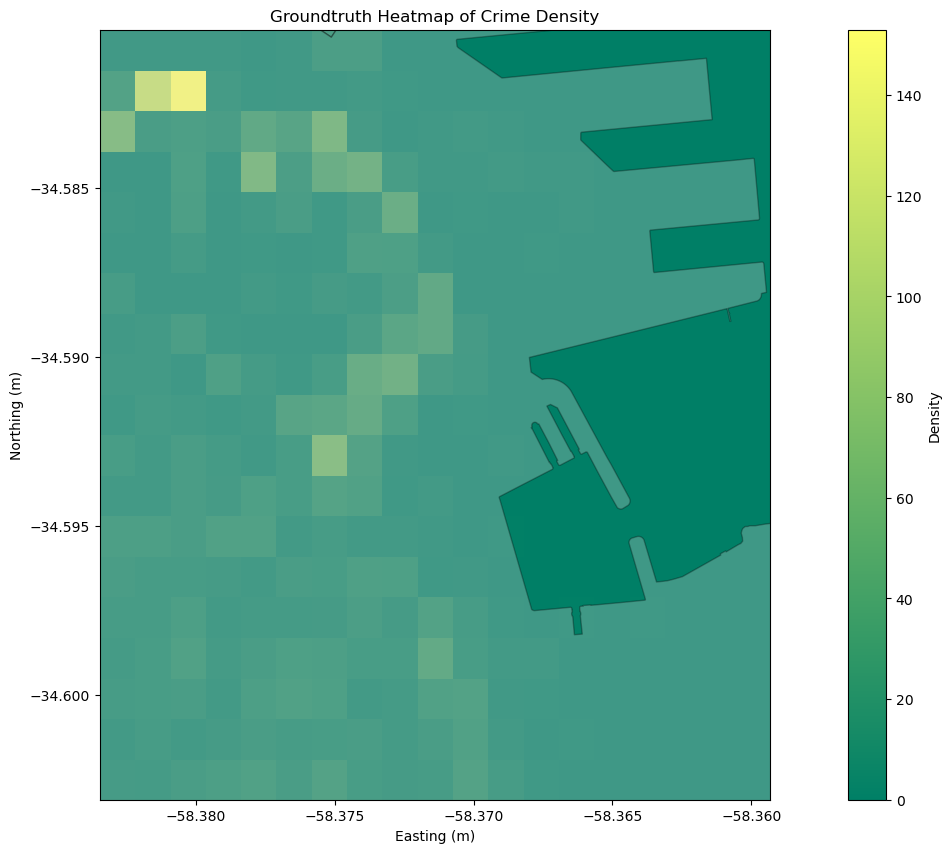

In [4]:
# Heat map on 2d coordinate without geo-boundary
n_bins = 20
xedges = np.linspace(lon_min, lon_max, n_bins)
yedges = np.linspace(lat_min, lat_max, n_bins)
heatmap_gt, xedges, yedges = np.histogram2d(longitude, latitude, bins=(xedges, yedges))
heatmap_gt = heatmap_gt.T

fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
# heatmap[heatmap == 0] = np.nan



heatmap_gt_plot = ax.imshow(heatmap_gt, origin='lower', cmap='summer', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
geo_data.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.3)

cbar = plt.colorbar(heatmap_gt_plot, ax=ax, orientation='vertical')
cbar.set_label('Density')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max]) 
plt.title('Groundtruth Heatmap of Crime Density')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.show()

In [5]:
tag = "buenos-aires-squared-v3"
crop_type = "highlight"
model_type = "siglip"
pcd, features, pcd_lat, pcd_lon = load_pcd_and_features(tag, crop_type)
model, tokenizer, encode_text = get_encode_fn(model_type=model_type)

(1000000, 1, 1152) (1000000, 3)


c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [42]:
queries = ["dangerous neighborhood", "safe neighborhood", "nature",] #"safe district", "urban neighborhood", "nature", "relaxed neighborhood", "unproblematic district"]

query_embed = encode_text(queries, model, tokenizer)
sim = features @ query_embed 
sim = sim.max(axis=1)

# danger_ratio = sim[:,0] - (sim[:,1] + 0.1*sim[:,2])
# danger_ratio = np.exp(danger_ratio)
danger_ratio = np.exp(sim[:,0]) / np.exp(sim).sum(axis=1)
danger_ratio[(features[:,0] == 0).all(axis=1)] = np.min(danger_ratio[(features[:,0] != 0).any(axis=1)])

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [43]:
from visualization_utils import visualize
visualize(pcd, danger_ratio, "features")

In [33]:
# convert to coordinates by linearly iterpolating between max and min
from scipy.stats import binned_statistic_2d
import numpy as np


# ret = binned_statistic_2d(pcd_lon, pcd_lat, danger_ratio, statistic=np.nanmean, bins=[xedges, yedges])
# heatmap_pred = ret.statistic.T

# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
# ax0.scatter(pcd_lon, pcd_lat, c=danger_ratio, cmap='viridis', s=1, alpha=0.5)
# heatmap_pred_plot = ax1.imshow(heatmap_pred, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')

In [44]:
correlation = np.corrcoef(heatmap_gt.flatten(), heatmap_pred.flatten())[0,1]
correlation

0.3269356632353438

In [45]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# fig.patch.set_facecolor('white')
# ax[0].set_facecolor('white')

# heatmap_pred_plot = ax[0].imshow(heatmap_pred, origin='lower', cmap='summer', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
# geo_data.plot(ax=ax[0], color='lightgrey', edgecolor='black', alpha=0.3)

# cbar = plt.colorbar(heatmap_pred_plot, ax=ax[0], orientation='vertical')
# cbar.set_label('Density')
# ax[0].set_xlim([lon_min, lon_max])
# ax[0].set_ylim([lat_min, lat_max]) 
# ax[0].set_title('Predicted Heatmap of Commited crimes')
# ax[0].set_xlabel('Easting (m)')
# ax[0].set_ylabel('Northing (m)')

# ax[1].set_facecolor('white')
# heatmap_pred_plot = ax[1].imshow(heatmap_gt, origin='lower', cmap='summer', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
# geo_data.plot(ax=ax[1], color='lightgrey', edgecolor='black', alpha=0.3)

# cbar = plt.colorbar(heatmap_pred_plot, ax=ax[1], orientation='vertical')
# cbar.set_label('Density')
# ax[1].set_xlim([lon_min, lon_max])
# ax[1].set_ylim([lat_min, lat_max]) 
# ax[1].set_title('Groundtruth Heatmap of Commited crimes')
# ax[1].set_xlabel('Easting (m)')
# ax[1].set_ylabel('Northing (m)')
# plt.suptitle(f'Predicted vd Heatmap of Point Density, Correlation: {correlation:.2f}')
# plt.show()


In [46]:
caba_rc = gpd.read_file("https://bitsandbricks.github.io/data/CABA_rc.geojson").to_crs(epsg=4326)

In [47]:
sample = True
np.random.seed(0)
lat_std = 0.001
lon_std = 0.001
n_samples = 100
sampled_gaussian_lat = np.array([np.random.normal(lat, lat_std, n_samples) for lat in crime_data["latitud"]]).flatten()
sampled_gaussian_lon = np.array([np.random.normal(lon, lon_std, n_samples) for lon in crime_data["longitud"]]).flatten()

In [48]:
if not sample:
    crime_geo_data = coord_to_geopandas(crime_data["latitud"], crime_data["longitud"], features={})
    caba_rc = aggregate_by_region(caba_rc, crime_geo_data, prefix="gt_crime_", project_on="points")
    caba_rc["crime_density"] = caba_rc['gt_crime_n_points'] / (caba_rc['AREA_KM2'] * len(years)) #caba_rc.geometry.area
else:
    crime_geo_data = coord_to_geopandas(sampled_gaussian_lat, sampled_gaussian_lon, features={})
    caba_rc = aggregate_by_region(caba_rc, crime_geo_data, prefix="gt_crime_", project_on="regions")
    caba_rc["crime_density"] = caba_rc['gt_crime_n_points'] / (n_samples * caba_rc['AREA_KM2'] * len(years)) #caba_rc.geometry.area


c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:85: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pcd_points_gpd["geometry"] = pcd_points_gpd.apply(lambda row: Point(row['long'], row['lat']), axis=1)
c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:97: FutureWarning: The default value

In [49]:
predicted_crime_geo_data = coord_to_geopandas(pcd_lat, pcd_lon, {"danger_ratio": danger_ratio}, resample_to_regular_grid=True)
caba_rc_by_point = aggregate_by_region(caba_rc.copy(), predicted_crime_geo_data, prefix="pred_", project_on="points")

c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:85: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pcd_points_gpd["geometry"] = pcd_points_gpd.apply(lambda row: Point(row['long'], row['lat']), axis=1)
c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [50]:
caba_rc_nonzero_by_point = caba_rc_by_point[caba_rc_by_point["pred_n_points"] > 0] # was .57 per district .44 per point
correlation_per_point = caba_rc_nonzero_by_point["crime_density"].corr(caba_rc_nonzero_by_point["danger_ratio"], method='pearson')
correlation_per_point

0.42214045432723163

In [51]:
caba_rc_by_region = aggregate_by_region(caba_rc.copy(), predicted_crime_geo_data, prefix="pred_", project_on="regions")
caba_rc_nonzero_per_region = caba_rc_by_region[caba_rc_by_region["pred_n_points"] > 0]

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:97: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averages = grouped.mean()


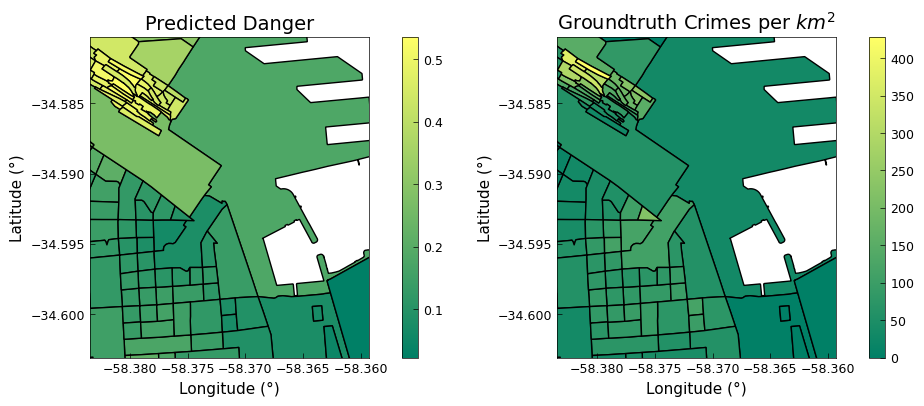

In [65]:
from visualization_utils import set_matplotlib_defaults
set_matplotlib_defaults()

fig, ax = plt.subplots(1, 2, figsize=(14 / 1.2, 5 / 1.2), tight_layout=True)
fig.patch.set_facecolor('white')
ax[0].set_facecolor('white')

caba_rc_nonzero_per_region.plot(column='pred_avg_danger_ratio', ax=ax[0], legend=True,
             cmap="summer", edgecolor='black')
ax[0].set_xlim([lon_min, lon_max])
ax[0].set_ylim([lat_min, lat_max]) 
ax[0].set_title('Predicted Danger')
ax[0].set_xlabel('Longitude (°)')
ax[0].set_ylabel('Latitude (°)')
# ax[0].set_xticks(ax[0].get_xticks()[::2], labels=[f"{x:,.3f}" for x in ax[0].get_xticks()[::2]], rotation=45)
# ax[0].set_yticks(ax[0].get_yticks()[::2], labels=[f"{y:,.2f}" for y in ax[0].get_yticks()[::2]])


ax[1].set_facecolor('white')
caba_rc_nonzero_per_region.plot(column='crime_density', ax=ax[1], legend=True,
             cmap="summer", edgecolor='black')
ax[1].set_xlim([lon_min, lon_max])
ax[1].set_ylim([lat_min, lat_max]) 
ax[1].set_title('Groundtruth Crimes per $km^2$')
ax[1].set_xlabel('Longitude (°)')
ax[1].set_ylabel('Latitude (°)')

# ax[1].set_xticks(ax[1].get_xticks(), labels=[f"{x:,.3f}" for x in ax[1].get_xticks()], rotation=45)
# ax[1].set_yticks(ax[1].get_yticks(), labels=[f"{y:,.2f}" for y in ax[1].get_yticks()])
# fig.savefig("crime_density.png", dpi=1200)
fig.savefig("crime_density.pdf")
# plt.suptitle(f'Predicted vd Heatmap of Point Density, Correlation: {correlation_per_district:.2f}')
plt.show()

## Few-shot Prediction

In [53]:
embedding_gdf = coord_to_geopandas(pcd_lat, pcd_lon, {"embeddings": list(features)}, resample_to_regular_grid=False)
embeddings_per_district = aggregate_by_region(caba_rc.copy().to_crs(epsg=4326), embedding_gdf, prefix="pred_", project_on="regions")
embeddings_per_district = embeddings_per_district[embeddings_per_district["pred_n_points"] > 0]

c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:85: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pcd_points_gpd["geometry"] = pcd_points_gpd.apply(lambda row: Point(row['long'], row['lat']), axis=1)
c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:97: FutureWarning: The default value

In [59]:
train_df = embeddings_per_district.sample(frac=0.3, random_state=42)
test_df = embeddings_per_district.drop(train_df.index)

train_X = np.concatenate([x for x in train_df['pred_embeddings'].to_list() if isinstance(x, list) and len(x) > 0], axis=0)
train_y = np.concatenate([[age for _ in range(len(x))] for x, age in zip(train_df['pred_embeddings'].to_list(), train_df["crime_density"].to_list()) if isinstance(x, list) and len(x) > 0], axis=0)

test_X = np.concatenate([x for x in test_df['pred_embeddings'].to_list() if isinstance(x, list) and len(x) > 0], axis=0)
test_y = np.concatenate([[age for _ in range(len(x))] for x, age in zip(test_df['pred_embeddings'].to_list(), test_df["crime_density"].to_list()) if isinstance(x, list) and len(x) > 0], axis=0)

if len(test_X) > 20000:
    np.random.seed(42) 
    random_indices = np.random.choice(len(test_X), 20000, replace=False)
    test_X = test_X[random_indices]
    test_y = test_y[random_indices]

print(test_X.shape, test_y.shape)
print(train_X.shape, train_y.shape)

(20000, 1, 1152) (20000,)
(382639, 1, 1152) (382639,)


In [60]:
len(test_df), len(train_df), len(embeddings_per_district), len(test_X), len(train_X)

(66, 28, 94, 20000, 382639)

In [61]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=50, metric='cosine')
print("Fitting")
knn.fit(train_X[:,0], train_y)
print("Predicting")
y_pred = knn.predict(test_X[:,0])

Fitting
Predicting


In [63]:
# eval
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

print(f"Mean squared error: {mean_squared_error(test_y, y_pred):.2f}")
print(f"R2 score: {r2_score(test_y, y_pred):.2f}")
print(f"Spearman corr {pd.Series(test_y).corr(pd.Series(y_pred), method='spearman'):.2f}")

Mean squared error: 2328.74
R2 score: 0.18
Spearman corr 0.61
